In [1]:
import numpy as np
import pymc3 as pm
import theano
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
from codebase.plot import *
import matplotlib.pyplot as plt
import theano.tensor as tt

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [2]:
def get_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return exp_eta/(1+exp_eta)


np.random.seed(5)
theta=dict()
beta = np.array([[1,0.8,0.9,0.5,1.3]]).T
alpha = np.array([0, 0.1, -0.1,-0.2,0.2])
z = np.array([[-2]])

y = np.random.binomial(1, get_pi_z(z, alpha, beta))
y.shape

(1, 5)

In [3]:
def initialize_vb_model():
    with pm.Model() as model:
        alpha_pm = pm.Data('alpha', np.zeros(5))
        beta_pm = pm.Data('beta', np.zeros((5,1)))
        y_pm = pm.Data('y', np.zeros((1,5)))
        z_pm = pm.Normal('z', mu=0,  sigma=1, shape=(1,))
    #     obs = pm.Normal('obs', z, 1, observed=y)
    #     p = get_pi_z(z, alpha_pm, beta_pm)
        p = pm.invlogit(alpha_pm + z_pm @ beta_pm.T)
        obs = pm.Bernoulli('obs', p=p, observed=y_pm)
        return model

def get_vb_params(y, alpha, beta):
    model = initialize_vb_model()
    with model:
        pm.set_data({
            'alpha': alpha,
            'beta': beta,
            'y': y
        })
        advi = pm.fit(method="fullrank_advi", n=10000)
    vb_mean = advi.mean.eval()
    vb_cov = advi.cov.eval()
    model.__exit__
    return vb_mean, vb_cov

In [4]:
vb_mean, vb_cov = get_vb_params(y, alpha, beta)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for 

In [5]:
# VB approx
x = np.linspace(-3,3,1000)
vb_pdf = multivariate_normal.pdf(x, mean= vb_mean, cov = vb_cov)

In [6]:

def get_log_likelihood(z,y,alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    s1 = (y*np.log(pi_z))+((1.-y)*(np.log(1. - pi_z)))
    return np.sum(s1)

def logprior(z):
    return norm.logpdf(z)

def get_neg_posterior(z,y,alpha, beta):
    return -1.*(get_log_likelihood(z,y,alpha, beta)+norm.logpdf(z))

def get_grad_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return (exp_eta *  beta.T)/(1+exp_eta)**2

def get_fisher_information(z, y, alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    grad_pi_z = get_grad_pi_z(z, alpha, beta)
    r1 =grad_pi_z**2
    r2 =pi_z*(1.-pi_z)
    return 1. + np.sum(r1/r2)

lglk = get_log_likelihood(z, y, alpha, beta) 
lglk

-3.5178466668006667

In [7]:
### analytical posterior pdf
x = np.linspace(-3,3,1000)
lposts = np.zeros(1000)
for i in range(1000):
    z = x[i].reshape((1,1))
    lposts[i] = get_log_likelihood(z, y, alpha, beta) + logprior(z)
posts = np.exp(lposts)
posts = posts/np.sum(posts*6/1000)
get_log_likelihood(z, y, alpha, beta) + logprior(z)

array([[-15.57550561]])

In [8]:
## Laplace approx
def get_laplace_approx(y, alpha, beta):
    res = minimize(get_neg_posterior, np.array([[1]]), args=(y, alpha, beta), method='BFGS')
    cov_matrix = get_fisher_information(res.x, y, alpha, beta)
    return multivariate_normal(mean = res.x, cov = cov_matrix**(-1))
lapldist =  get_laplace_approx(y, alpha, beta)
laplace_pdf = lapldist.pdf(x)

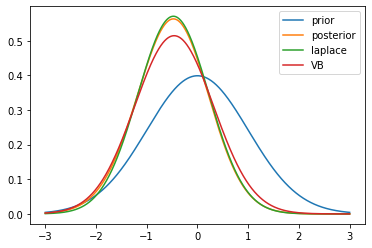

In [9]:
plt.plot(x,norm.pdf(x),label='prior')
# plt.plot(x,np.squeeze(norm.pdf(x,M,np.sqrt(V))),label='Kostas_laplace')
plt.plot(x,posts,label='posterior')
plt.plot(x,laplace_pdf,label='laplace')
plt.plot(x,vb_pdf,label='VB')
plt.legend()

In [10]:
# 2 D example for VB
np.random.seed(5)
theta=dict()
alpha = np.array([0, 0.1, -0.1,-0.2,0.2])
beta = np.array([[1,0.8,0.9,0.5,1.3],
                [1,0.8,0.9,0.5,1.3]]).T
z = np.array([[-2,-2]])
y = np.random.binomial(1, get_pi_z(z, alpha, beta))


In [11]:
with pm.Model() as model:
    alpha = pm.Data('alpha', alpha)
    beta = pm.Data('beta', beta)
    y = pm.Data('y', y)
    z = pm.Normal('z', 0, 1, shape=(2,))
#     obs = pm.Normal('obs', z, 1, observed=y)
    p = tt.nnet.softmax(alpha + z @ beta.T)
    obs = pm.Bernoulli('obs', p=p, observed=y)


/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  import sys
